In [17]:
import tensorflow_hub as hub
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2023-05-21 15:17:42.935599: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-21 15:17:44.142426: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2023-05-21 15:17:44.215294: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2023-05-21 15:17:44.291854: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2023-05-21 15:17:44.414251: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2023-05-21 15:17:44.484802: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.


In [4]:
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

2023-05-21 15:17:53.244757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


tf.Tensor(
[[-0.03133017 -0.06338634 -0.01607501 ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.0508086  -0.01652434  0.01573779 ...  0.00976657  0.03170121
   0.01788118]], shape=(2, 512), dtype=float32)


In [14]:
with open('data.txt', 'r') as data:
    lines = data.readlines()
    vectors = embed(lines).numpy()

[[ 0.01648    -0.01784902 -0.02272825 ...  0.05319935 -0.06954068
  -0.06111697]
 [ 0.03147412 -0.05917354 -0.04212883 ...  0.01293696 -0.07429665
  -0.07658733]
 [-0.01790788 -0.07632141 -0.04011651 ...  0.01682439 -0.06283353
   0.0097547 ]
 ...
 [ 0.06743738 -0.00274703  0.06826436 ...  0.04221842 -0.0325926
  -0.06513211]
 [ 0.01537482 -0.05995568  0.02596983 ... -0.0380376  -0.0504935
   0.00805367]
 [-0.0263995   0.07417224  0.00281631 ...  0.04144129  0.02296199
  -0.0512626 ]]


In [19]:
k = 30
kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2)
cluster_matrix = kmeans.fit_transform(vectors)
labels = kmeans.labels_

(array([810., 575., 214., 406., 176., 181., 187., 494., 765.,  97., 249.,
        841., 323., 322., 386., 377., 210., 236., 198., 339., 774., 288.,
        251., 272., 116., 151., 456., 245., 326., 126.]),
 array([ 0.        ,  0.96666667,  1.93333333,  2.9       ,  3.86666667,
         4.83333333,  5.8       ,  6.76666667,  7.73333333,  8.7       ,
         9.66666667, 10.63333333, 11.6       , 12.56666667, 13.53333333,
        14.5       , 15.46666667, 16.43333333, 17.4       , 18.36666667,
        19.33333333, 20.3       , 21.26666667, 22.23333333, 23.2       ,
        24.16666667, 25.13333333, 26.1       , 27.06666667, 28.03333333,
        29.        ]),
 <BarContainer object of 30 artists>)

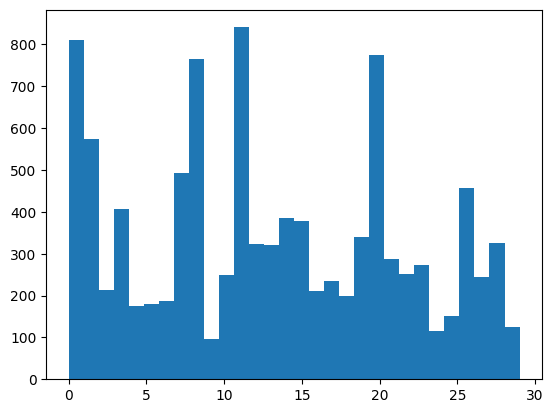

In [20]:
# plot the number of points in each cluster
plt.hist(labels, bins=k)

In [22]:
# print the top 10 words in each cluster
for i in range(k):
    print(f'Cluster {i}')
    for j in np.argsort(cluster_matrix[:, i])[:10]:
        print('\t', lines[j])

Cluster 0
	 stupid true

	 lol ignorant

	 meant move

	 dont know legitimate yeah

	 funny thought thing math

	 someoen playing guitar

	 well alright got

	 messed study

	 ossobuco could enema

	 someone fell horse

Cluster 1
	 proliferation security initiative calls stopping searching ships suspected carrying weapons mass destruction 

	 indonesia police shoot dead suspected militants bali

	 united states government accused iranian government trying develop nuclear weapons cover civilian nuclear program 

	 us surveillance aircraft join hunt kidnapped nigerian girls

	 gunmen ambush police boat nigeria oil region

	 us soldier accused afghan massacre hires prominent criminal lawyer

	 reports state syrian government concealing nuclear facility attacked site 

	 elbaradei states middle east peace deal reached parallel security agreement based eradicating weapons mass destruction region 

	 gunmen surround libyan foreign ministry push demands

	 iranian government denied accusation